# Exercise 04 : Hyper-parameter Tuning

In the practical machine learning works, it’s very hard to find best parameters - such as learning rare (in neural networks), iterations or epoch, [regression family](https://tsmatz.wordpress.com/2017/08/30/glm-regression-logistic-poisson-gaussian-gamma-tutorial-with-r/), kernel functions (in svm etc), [regularization parameters](https://tsmatz.wordpress.com/2017/09/13/overfitting-for-regression-and-deep-learning/), so on and so forth. In Spark machine learning, you can quickly find best parameters by scaling Spark massive workers.

In this lab, we change the source code of Exercise 03 and find the best values of parameters - "learningRate" and "numLeaves" - for LightGBM classifier in Exercise 03 by grid search. (Here we explore only classification's parameters, but you can also tune transformation's parameters.)

Before starting,

- Download [flight_weather.csv](https://1drv.ms/u/s!AuopXnMb-AqcgbZD7jEX6OTb4j8CTQ?e=KkeDdT) into your blob container. (See "Exercise 01 : Storage Settings".)
- Install MMLSpark to use LightGBM into your cluster. (See "Exercise 03 : Spark Machine Learning Pipeline".)

> Note : You can also use ```CrossValidator()``` instead of using ```TrainValidationSplit()```, but please be care for training overheads when using ```CrossValidator()```.    
The word "Cross Validation" means : For example, by setting ```numFolds=5``` in ```CrossValidator()```, 4/5 is used for training and 1/5 is for testing, and moreover each pairs are replaced and averaged. As a result, 5 pairs of dataset are used and the training occurs (3 params x 3 params) x 5 pairs = 45 times. (See "[ML Tuning: model selection and hyperparameter tuning](https://spark.apache.org/docs/latest/ml-tuning.html)" in official Spark document.)

*back to [index](https://github.com/tsmatz/azure-databricks-exercise)*

In [0]:
%pip install LightGBM

Python interpreter will be restarted.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-0b70f35b-3746-4ee6-9902-5f44f4282ea0/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.


In [0]:
# Read dataset
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, TimestampType
df = (sqlContext.read.format("csv").
  option("header", "true").
  option("nullValue", "NA").
  option("inferSchema", True).
  load("file:/tmp/flight_weather.csv"))

In [0]:
display(df)

X.1,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_STATE_ABR,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,X,VisibilityOrigin,DryBulbCelsiusOrigin,DewPointCelsiusOrigin,RelativeHumidityOrigin,WindSpeedOrigin,AltimeterOrigin,VisibilityDest,DryBulbCelsiusDest,DewPointCelsiusDest,RelativeHumidityDest,WindSpeedDest,AltimeterDest
1,2012,1,4,3,2012-01-04,AA,N320AA,1,12478,JFK,NY,12892,LAX,CA,9,904,4,4,0,0,18,922,1131,20,12,1151,-34,0,0,-2,0,,0,385,347,309,1,2475,10,null,null,null,null,null,null,10.0,-3.9,-19.4,29.0,7.0,30.1,10.0,17.2,10.6,65.0,3.0,30.18
2,2012,1,20,5,2012-01-20,AA,N327AA,1,12478,JFK,NY,12892,LAX,CA,9,858,-2,0,0,-1,21,919,1212,15,12,1227,2,2,0,0,0,,0,385,389,353,1,2475,10,null,null,null,null,null,null,10.0,0.0,-16.7,28.0,15.0,30.21,10.0,13.9,10.0,78.0,6.0,30.09
3,2012,1,5,4,2012-01-05,AA,N329AA,2,12892,LAX,CA,12478,JFK,NY,9,925,-5,0,0,-1,18,943,1741,13,18,1754,-6,0,0,-1,0,,0,330,329,298,1,2475,10,null,null,null,null,null,null,10.0,18.3,7.2,49.0,8.0,30.02,10.0,-0.6,-5.0,72.0,9.0,29.99
4,2012,1,21,6,2012-01-21,AA,N327AA,2,12892,LAX,CA,12478,JFK,NY,9,null,null,null,null,null,null,null,null,null,18,null,null,null,null,null,1,B,0,330,null,null,1,2475,10,null,null,null,null,null,null,10.0,15.6,6.7,56.0,18.0,29.99,10.0,-3.3,-8.3,69.0,13.0,30.28
5,2012,1,6,5,2012-01-06,AA,N336AA,3,12478,JFK,NY,12892,LAX,CA,12,1151,-9,0,0,-1,14,1205,1436,7,15,1443,-32,0,0,-2,0,,0,375,352,331,1,2475,10,null,null,null,null,null,null,10.0,8.9,0.0,54.0,13.0,29.78,6.0,13.3,11.7,90.0,0.0,29.99
6,2012,1,22,7,2012-01-22,AA,N323AA,3,12478,JFK,NY,12892,LAX,CA,12,1154,-6,0,0,-1,23,1217,1455,13,15,1508,-7,0,0,-1,0,,0,375,374,338,1,2475,10,null,null,null,null,null,null,10.0,0.0,-4.4,72.0,6.0,30.5,10.0,12.8,9.4,80.0,3.0,30.14
7,2012,1,7,6,2012-01-07,AA,N336AA,4,12892,LAX,CA,12478,JFK,NY,12,1223,8,8,0,0,15,1238,2018,3,20,2021,-24,0,0,-2,0,,0,330,298,280,1,2475,10,null,null,null,null,null,null,6.0,12.8,10.0,83.0,0.0,30.02,10.0,7.2,-4.4,44.0,15.0,30.01
8,2012,1,23,1,2012-01-23,AA,N336AA,4,12892,LAX,CA,12478,JFK,NY,12,1207,-8,0,0,-1,19,1226,2022,9,20,2031,-14,0,0,-1,0,,0,330,324,296,1,2475,10,null,null,null,null,null,null,10.0,12.2,9.4,83.0,0.0,29.98,6.0,8.15,7.9,98.0,8.0,29.91
9,2012,1,8,7,2012-01-08,AA,N357AA,5,11298,DFW,TX,12173,HNL,HI,13,1413,73,73,1,4,12,1425,1759,2,17,1801,26,26,1,1,0,,0,515,468,454,1,3784,11,26,0,0,0,0,null,9.0,11.9,8.96666666666667,81.0,8.33333333333333,30.0766666666667,10.0,20.0,17.8,87.0,0.0,30.09
10,2012,1,24,2,2012-01-24,AA,N380AA,5,11298,DFW,TX,12173,HNL,HI,13,1256,-4,0,0,-1,16,1312,1638,3,17,1641,-54,0,0,-2,0,,0,515,465,446,1,3784,11,null,null,null,null,null,null,7.5,12.35,9.5,83.5,8.5,29.94,10.0,21.7,18.9,84.0,0.0,30.01


In [0]:
# ARR_DEL15 = 1 if it's canceled.
from pyspark.sql.functions import when
df = df.withColumn("ARR_DEL15", when(df["CANCELLED"] == 1, 1).otherwise(df["ARR_DEL15"]))

In [0]:
# Remove flights if it's diverted.
df = df.filter(df["DIVERTED"] == 0)

In [0]:
# Select required columns
df = df.select(
  "ARR_DEL15",
  "MONTH",
  "DAY_OF_WEEK",
  "UNIQUE_CARRIER",
  "ORIGIN",
  "DEST",
  "CRS_DEP_TIME",
  "CRS_ARR_TIME",
  "RelativeHumidityOrigin",
  "AltimeterOrigin",
  "DryBulbCelsiusOrigin",
  "WindSpeedOrigin",
  "VisibilityOrigin",
  "DewPointCelsiusOrigin",
  "RelativeHumidityDest",
  "AltimeterDest",
  "DryBulbCelsiusDest",
  "WindSpeedDest",
  "VisibilityDest",
  "DewPointCelsiusDest")

In [0]:
# Drop rows with null values
df = df.dropna()

In [0]:
# Convert categorical values to indexer (0, 1, ...)
from pyspark.ml.feature import StringIndexer
uniqueCarrierIndexer = StringIndexer(inputCol="UNIQUE_CARRIER", outputCol="Indexed_UNIQUE_CARRIER").fit(df)
originIndexer = StringIndexer(inputCol="ORIGIN", outputCol="Indexed_ORIGIN").fit(df)
destIndexer = StringIndexer(inputCol="DEST", outputCol="Indexed_DEST").fit(df)
arrDel15Indexer = StringIndexer(inputCol="ARR_DEL15", outputCol="Indexed_ARR_DEL15").fit(df)

In [0]:
display(df)

ARR_DEL15,MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,RelativeHumidityOrigin,AltimeterOrigin,DryBulbCelsiusOrigin,WindSpeedOrigin,VisibilityOrigin,DewPointCelsiusOrigin,RelativeHumidityDest,AltimeterDest,DryBulbCelsiusDest,WindSpeedDest,VisibilityDest,DewPointCelsiusDest
0,1,3,AA,JFK,LAX,9,12,29.0,30.1,-3.9,7.0,10.0,-19.4,65.0,30.18,17.2,3.0,10.0,10.6
0,1,5,AA,JFK,LAX,9,12,28.0,30.21,0.0,15.0,10.0,-16.7,78.0,30.09,13.9,6.0,10.0,10.0
0,1,4,AA,LAX,JFK,9,18,49.0,30.02,18.3,8.0,10.0,7.2,72.0,29.99,-0.6,9.0,10.0,-5.0
1,1,6,AA,LAX,JFK,9,18,56.0,29.99,15.6,18.0,10.0,6.7,69.0,30.28,-3.3,13.0,10.0,-8.3
0,1,5,AA,JFK,LAX,12,15,54.0,29.78,8.9,13.0,10.0,0.0,90.0,29.99,13.3,0.0,6.0,11.7
0,1,7,AA,JFK,LAX,12,15,72.0,30.5,0.0,6.0,10.0,-4.4,80.0,30.14,12.8,3.0,10.0,9.4
0,1,6,AA,LAX,JFK,12,20,83.0,30.02,12.8,0.0,6.0,10.0,44.0,30.01,7.2,15.0,10.0,-4.4
0,1,1,AA,LAX,JFK,12,20,83.0,29.98,12.2,0.0,10.0,9.4,98.0,29.91,8.15,8.0,6.0,7.9
1,1,7,AA,DFW,HNL,13,17,81.0,30.0766666666667,11.9,8.33333333333333,9.0,8.96666666666667,87.0,30.09,20.0,0.0,10.0,17.8
0,1,2,AA,DFW,HNL,13,17,83.5,29.94,12.35,8.5,7.5,9.5,84.0,30.01,21.7,0.0,10.0,18.9


In [0]:
# Assemble feature columns
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
  inputCols = [
    "MONTH",
    "DAY_OF_WEEK",
    "Indexed_UNIQUE_CARRIER",
    "Indexed_ORIGIN",
    "Indexed_DEST",
    "CRS_DEP_TIME",
    "CRS_ARR_TIME",
    "RelativeHumidityOrigin",
    "AltimeterOrigin",
    "DryBulbCelsiusOrigin",
    "WindSpeedOrigin",
    "VisibilityOrigin",
    "DewPointCelsiusOrigin",
    "RelativeHumidityDest",
    "AltimeterDest",
    "DryBulbCelsiusDest",
    "WindSpeedDest",
    "VisibilityDest",
    "DewPointCelsiusDest"],
  outputCol = "features")

In [0]:
# Define classifier
# from mmlspark.lightgbm import LightGBMClassifier
# from mmlspark.LightGBMRegressor import LightGBMRegressorr
# from mmlspark.LightGBMRegressor import _LightGBMRegressor
# from mmlspark.lightgbm import _LightGBMRegressor
from synapse.ml.lightgbm import LightGBMClassifier
classifier = LightGBMClassifier(featuresCol="features", labelCol="ARR_DEL15", numIterations=100)

In [0]:
# Create pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[uniqueCarrierIndexer, originIndexer, destIndexer, arrDel15Indexer, assembler, classifier])

Note : The following execution will take a long time, because of a serial evaluation by default.    
Use ```setParallelism()``` to improve performance.

In [0]:
# Run pipeline with ParamGridBuilder
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# 3 x 3 = 9 times training occurs
paramGrid = ParamGridBuilder() \
 .addGrid(classifier.learningRate, [0.1, 0.3, 0.5]) \
 .addGrid(classifier.numLeaves, [100, 150, 200]) \
 .build()
# Set appropriate parallelism by setParallelism() in production
# (It takes a long time)
tvs = TrainValidationSplit(
  estimator=pipeline,
  estimatorParamMaps=paramGrid,
  evaluator=MulticlassClassificationEvaluator(labelCol="ARR_DEL15", predictionCol="prediction"),
  trainRatio=0.8)  # data is separated by 80% and 20%, in which the former is used for training and the latter for evaluation
model = tvs.fit(df)

/databricks/spark/python/pyspark/ml/util.py:839: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
  warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)


In [0]:
feature_cols1 = df.columns[1:]
print (' '.join(feature_cols1))

MONTH DAY_OF_WEEK UNIQUE_CARRIER ORIGIN DEST CRS_DEP_TIME CRS_ARR_TIME RelativeHumidityOrigin AltimeterOrigin DryBulbCelsiusOrigin WindSpeedOrigin VisibilityOrigin DewPointCelsiusOrigin RelativeHumidityDest AltimeterDest DryBulbCelsiusDest WindSpeedDest VisibilityDest DewPointCelsiusDest


In [0]:
df_new = StringIndexer(inputCol="UNIQUE_CARRIER", outputCol="Indexed_UNIQUE_CARRIER").fit(df).transform(df)
df_new1 =df_new.drop("UNIQUE_CARRIER")

In [0]:
display(df_new1)

ARR_DEL15,MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,RelativeHumidityOrigin,AltimeterOrigin,DryBulbCelsiusOrigin,WindSpeedOrigin,VisibilityOrigin,DewPointCelsiusOrigin,RelativeHumidityDest,AltimeterDest,DryBulbCelsiusDest,WindSpeedDest,VisibilityDest,DewPointCelsiusDest,Indexed_UNIQUE_CARRIER
0,1,3,JFK,LAX,9,12,29.0,30.1,-3.9,7.0,10.0,-19.4,65.0,30.18,17.2,3.0,10.0,10.6,3.0
0,1,5,JFK,LAX,9,12,28.0,30.21,0.0,15.0,10.0,-16.7,78.0,30.09,13.9,6.0,10.0,10.0,3.0
0,1,4,LAX,JFK,9,18,49.0,30.02,18.3,8.0,10.0,7.2,72.0,29.99,-0.6,9.0,10.0,-5.0,3.0
1,1,6,LAX,JFK,9,18,56.0,29.99,15.6,18.0,10.0,6.7,69.0,30.28,-3.3,13.0,10.0,-8.3,3.0
0,1,5,JFK,LAX,12,15,54.0,29.78,8.9,13.0,10.0,0.0,90.0,29.99,13.3,0.0,6.0,11.7,3.0
0,1,7,JFK,LAX,12,15,72.0,30.5,0.0,6.0,10.0,-4.4,80.0,30.14,12.8,3.0,10.0,9.4,3.0
0,1,6,LAX,JFK,12,20,83.0,30.02,12.8,0.0,6.0,10.0,44.0,30.01,7.2,15.0,10.0,-4.4,3.0
0,1,1,LAX,JFK,12,20,83.0,29.98,12.2,0.0,10.0,9.4,98.0,29.91,8.15,8.0,6.0,7.9,3.0
1,1,7,DFW,HNL,13,17,81.0,30.0766666666667,11.9,8.33333333333333,9.0,8.96666666666667,87.0,30.09,20.0,0.0,10.0,17.8,3.0
0,1,2,DFW,HNL,13,17,83.5,29.94,12.35,8.5,7.5,9.5,84.0,30.01,21.7,0.0,10.0,18.9,3.0


In [0]:
feature_cols = [
    "MONTH",
    "DAY_OF_WEEK",
    "Indexed_UNIQUE_CARRIER",
    "CRS_DEP_TIME",
    "CRS_ARR_TIME",
    "RelativeHumidityOrigin",
    "AltimeterOrigin",
    "DryBulbCelsiusOrigin",
    "WindSpeedOrigin",
    "VisibilityOrigin",
    "DewPointCelsiusOrigin",
    "RelativeHumidityDest",
    "AltimeterDest",
    "DryBulbCelsiusDest",
    "WindSpeedDest",
    "VisibilityDest",
    "DewPointCelsiusDest"]


In [0]:
train, test = df_new1.randomSplit([0.85, 0.15], seed=1)
from pyspark.ml.feature import VectorAssembler
# feature_cols = df_new1.columns[1:]
# featurizer = VectorAssembler(
#     inputCols=feature_cols,
#     outputCol='features'
# )

featurizer = VectorAssembler(
  inputCols = [
    "MONTH",
    "DAY_OF_WEEK",
    "Indexed_UNIQUE_CARRIER",
    "CRS_DEP_TIME",
    "CRS_ARR_TIME",
    "RelativeHumidityOrigin",
    "AltimeterOrigin",
    "DryBulbCelsiusOrigin",
    "WindSpeedOrigin",
    "VisibilityOrigin",
    "DewPointCelsiusOrigin",
    "RelativeHumidityDest",
    "AltimeterDest",
    "DryBulbCelsiusDest",
    "WindSpeedDest",
    "VisibilityDest",
    "DewPointCelsiusDest"],
  outputCol = "features")

train_data = featurizer.transform(train)['ARR_DEL15', 'features']
test_data = featurizer.transform(test)['ARR_DEL15', 'features']
model1 = LightGBMClassifier(featuresCol="features", labelCol="ARR_DEL15", numIterations=100)
model1 = model1.fit(train_data)

In [0]:
model1.getFeatureImportances()

Out[50]: [114.0,
 366.0,
 534.0,
 162.0,
 77.0,
 122.0,
 245.0,
 235.0,
 134.0,
 59.0,
 141.0,
 131.0,
 223.0,
 172.0,
 120.0,
 60.0,
 105.0]

f_index: Index(['VisibilityOrigin', 'VisibilityDest', 'CRS_ARR_TIME',
       'DewPointCelsiusDest', 'MONTH', 'WindSpeedDest',
       'RelativeHumidityOrigin', 'RelativeHumidityDest', 'WindSpeedOrigin',
       'DewPointCelsiusOrigin', 'CRS_DEP_TIME', 'DryBulbCelsiusDest',
       'AltimeterDest', 'DryBulbCelsiusOrigin', 'AltimeterOrigin',
       'DAY_OF_WEEK', 'Indexed_UNIQUE_CARRIER'],
      dtype='object')
f_values: [ 59.  60.  77. 105. 114. 120. 122. 131. 134. 141. 162. 172. 223. 235.
 245. 366. 534.]


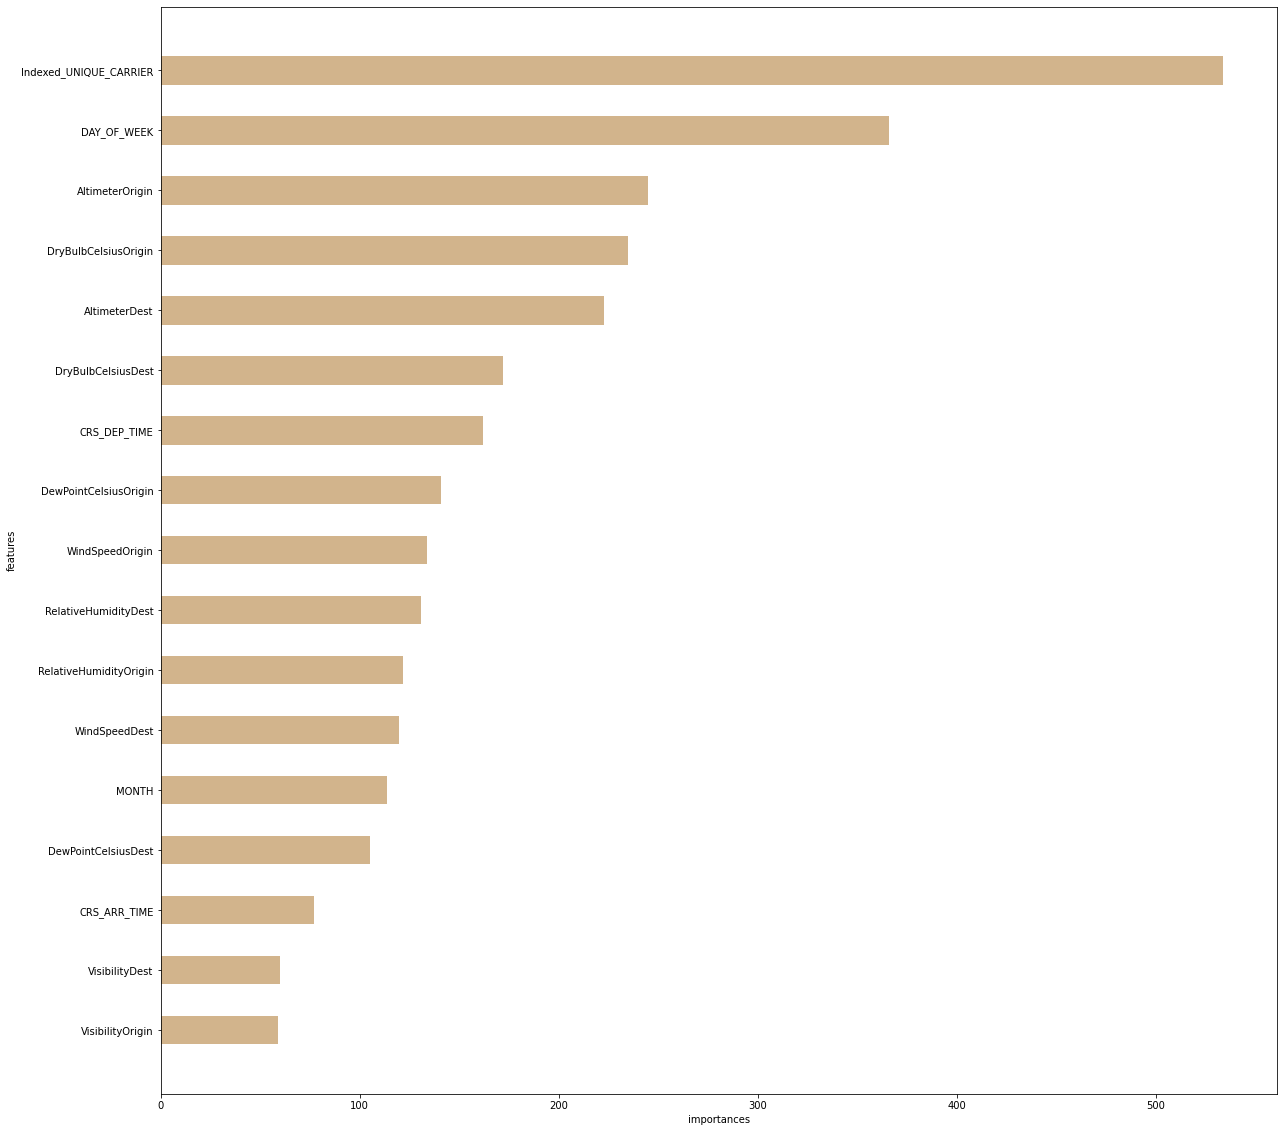

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = model1.getFeatureImportances()
# fi = pd.Series(feature_importances,index = feature_cols)
fi = pd.Series(feature_importances,index = feature_cols)
fi = fi.sort_values(ascending = True)
f_index = fi.index
f_values = fi.values
 
# print feature importances 
print ('f_index:',f_index)
print ('f_values:',f_values)

# plot
x_index = list(range(len(fi)))
x_index = [x/len(fi) for x in x_index]
plt.rcParams['figure.figsize'] = (20,20)
plt.barh(x_index,f_values,height = 0.028 ,align="center",color = 'tan',tick_label=f_index)
plt.xlabel('importances')
plt.ylabel('features')
plt.show()

In [0]:
# View all results (accuracy) by each params
list(zip(model.validationMetrics, model.getEstimatorParamMaps()))

Out[17]: [(0.790246118187261,
  {Param(parent='LightGBMClassifier_92b7dd23327e', name='learningRate', doc='Learning rate or shrinkage rate'): 0.1,
   Param(parent='LightGBMClassifier_92b7dd23327e', name='numLeaves', doc='Number of leaves'): 100}),
 (0.7943267311310116,
  {Param(parent='LightGBMClassifier_92b7dd23327e', name='learningRate', doc='Learning rate or shrinkage rate'): 0.1,
   Param(parent='LightGBMClassifier_92b7dd23327e', name='numLeaves', doc='Number of leaves'): 150}),
 (0.7968622085430168,
  {Param(parent='LightGBMClassifier_92b7dd23327e', name='learningRate', doc='Learning rate or shrinkage rate'): 0.1,
   Param(parent='LightGBMClassifier_92b7dd23327e', name='numLeaves', doc='Number of leaves'): 200}),
 (0.7980293429480926,
  {Param(parent='LightGBMClassifier_92b7dd23327e', name='learningRate', doc='Learning rate or shrinkage rate'): 0.3,
   Param(parent='LightGBMClassifier_92b7dd23327e', name='numLeaves', doc='Number of leaves'): 100}),
 (0.8016723881792389,
  {Param(p

In [0]:
# Predict using best model
df10 = df.limit(10)
model.bestModel.transform(df10)\
  .select("ARR_DEL15", "prediction")\
  .show()

+---------+----------+
|ARR_DEL15|prediction|
+---------+----------+
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        1|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        0|       0.0|
|        1|       0.0|
|        0|       0.0|
+---------+----------+

